<a href="https://colab.research.google.com/github/DommiiUdomp/CNN/blob/main/JustMap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
import tensorflow as tf
import numpy as np
import pandas as pd
from PIL import Image
from scipy import optimize
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
import ee

# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=yGqXcZxZx8f0KeoBP-9hFIpuUjH4PGpXzSZTCNPGkXM&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AX4XfWizEQnrDdJeIv-bg2ycMyRACIAYI0kVwU3VdfY2ccCE6xUAAkEKjfo

Successfully saved authorization token.


In [3]:
#test API
# Print the elevation of Mount Everest.
dem = ee.Image('USGS/SRTMGL1_003')
xy = ee.Geometry.Point([86.9250, 27.9881])
elev = dem.sample(xy, 30).first().get('elevation').getInfo()
print('Mount Everest elevation (m):', elev)

Mount Everest elevation (m): 8729


# **Land Surface Temperature**

**Data collection**

In [5]:
# Import the MODIS land cover collection.
lc = ee.ImageCollection('MODIS/006/MCD12Q1')

# Import the MODIS land surface temperature collection.
lst = ee.ImageCollection("MODIS/006/MOD11A1")

# Import the USGS ground elevation image.
elv = ee.Image('USGS/SRTMGL1_003')

# Import the The NASA GES DISC at NASA Goddard Space Flight Center
mix = ee.ImageCollection("NASA/GLDAS/V021/NOAH/G025/T3H")

#USDA soil taxonomy great groups
soil = ee.Image("OpenLandMap/SOL/SOL_GRTGROUP_USDA-SOILTAX_C/v01")


# Initial date of interest (inclusive).
i_date = '2017-01-01'

# Final date of interest (exclusive).
f_date = '2021-08-01'

# Selection of appropriate bands and dates for LST.
lst = lst.select('LST_Day_1km', 'QC_Day').filterDate(i_date, f_date)

# Define the urban location of interest as a point near Budapest, Hungary.
u_lon = 19.04
u_lat = 47.4979
u_poi = ee.Geometry.Point(u_lon, u_lat)

# Define the rural location of interest as a point away from the city Szeged.
r_lon = 20.1414
r_lat = 46.2530
r_poi = ee.Geometry.Point(r_lon, r_lat)

In [6]:
scale = 1000  # scale in meters

# Print the elevation near Budapest, Hungary.
elv_urban_point = elv.sample(u_poi, scale).first().get('elevation').getInfo()
print('Ground elevation at urban point:', elv_urban_point, 'm')

# Calculate and print the mean value of the LST collection at the point.
lst_urban_point = lst.mean().sample(u_poi, scale).first().get('LST_Day_1km').getInfo()
print('Average daytime LST at urban point:', round(lst_urban_point*0.02 -273.15, 2), '°C')

# Print the land cover type at the point.
lc_urban_point = lc.first().sample(u_poi, scale).first().get('LC_Type1').getInfo()
print('Land cover value at urban point is:', lc_urban_point)

Ground elevation at urban point: 105 m
Average daytime LST at urban point: 21.13 °C
Land cover value at urban point is: 13


In [14]:
# Print the soil type at the point.
soil_urban_point = soil.sample(u_poi, scale).first().get('grtgroup').getInfo()
print('Soil at urban point is:', soil_urban_point)

Soil at urban point is: 289


In [15]:
# Get the data for the pixel intersecting the point in urban area.
lst_u_poi = lst.getRegion(u_poi, scale).getInfo()

# Get the data for the pixel intersecting the point in rural area.
lst_r_poi = lst.getRegion(r_poi, scale).getInfo()

# Preview the result.
lst_u_poi[:5]

[['id', 'longitude', 'latitude', 'time', 'LST_Day_1km', 'QC_Day'],
 ['2017_01_01', 19.03979244691326, 47.4984206478197, 1483228800000, None, 2],
 ['2017_01_02', 19.03979244691326, 47.4984206478197, 1483315200000, None, 2],
 ['2017_01_03', 19.03979244691326, 47.4984206478197, 1483401600000, 13648, 81],
 ['2017_01_04', 19.03979244691326, 47.4984206478197, 1483488000000, None, 2]]

In [16]:
def ee_array_to_df(arr, list_of_bands):
    """Transforms client-side ee.Image.getRegion array to pandas.DataFrame."""
    df = pd.DataFrame(arr)

    # Rearrange the header.
    headers = df.iloc[0]
    df = pd.DataFrame(df.values[1:], columns=headers)

    # Remove rows without data inside.
    df = df[['longitude', 'latitude', 'time', *list_of_bands]].dropna()

    # Convert the data to numeric values.
    for band in list_of_bands:
        df[band] = pd.to_numeric(df[band], errors='coerce')

    # Convert the time field into a datetime.
    df['datetime'] = pd.to_datetime(df['time'], unit='ms')

    # Keep the columns of interest.
    df = df[['time','datetime',  *list_of_bands]]

    return df

In [19]:
lst_df_urban = ee_array_to_df(lst_u_poi,['LST_Day_1km'])

def t_modis_to_celsius(t_modis):
    """Converts MODIS LST units to degrees Celsius."""
    t_celsius =  0.02*t_modis - 273.15
    return t_celsius

# Apply the function to get temperature in celsius.
lst_df_urban['LST_Day_1km'] = lst_df_urban['LST_Day_1km'].apply(t_modis_to_celsius)

# Do the same for the rural point.
lst_df_rural = ee_array_to_df(lst_r_poi,['LST_Day_1km'])
lst_df_rural['LST_Day_1km'] = lst_df_rural['LST_Day_1km'].apply(t_modis_to_celsius)

lst_df_urban.head()

,time,datetime,LST_Day_1km
2,1483401600000,2017-01-03,-0.19
4,1483574400000,2017-01-05,0.97
5,1483660800000,2017-01-06,-4.85
6,1483747200000,2017-01-07,-7.05
7,1483833600000,2017-01-08,-6.39


In [20]:
lst_df_urban.tail()

,time,datetime,LST_Day_1km
1668,1627344000000,2021-07-27,34.99
1669,1627430400000,2021-07-28,32.49
1670,1627516800000,2021-07-29,35.91
1671,1627603200000,2021-07-30,34.73
1672,1627689600000,2021-07-31,32.39


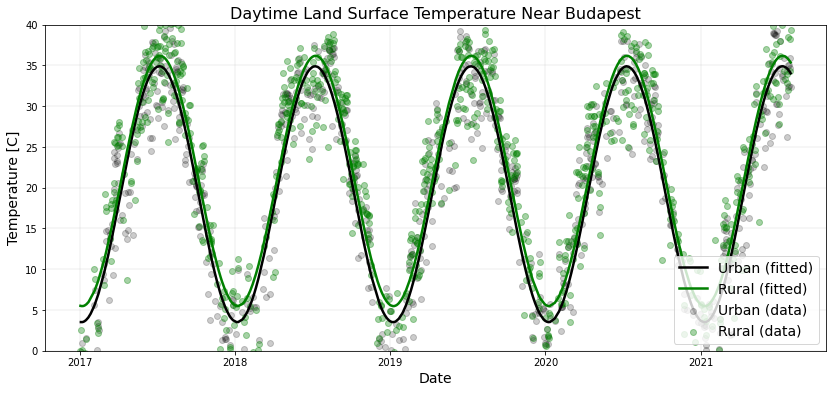

In [21]:
# Fitting curves.
## First, extract x values (times) from the dfs.
x_data_u = np.asanyarray(lst_df_urban['time'].apply(float))  # urban
x_data_r = np.asanyarray(lst_df_rural['time'].apply(float))  # rural

## Secondly, extract y values (LST) from the dfs.
y_data_u = np.asanyarray(lst_df_urban['LST_Day_1km'].apply(float))  # urban
y_data_r = np.asanyarray(lst_df_rural['LST_Day_1km'].apply(float))  # rural

## Then, define the fitting function with parameters.
def fit_func(t, lst0, delta_lst, tau, phi):
    return lst0 + (delta_lst/2)*np.sin(2*np.pi*t/tau + phi)

## Optimize the parameters using a good start p0.
lst0 = 20
delta_lst = 40
tau = 365*24*3600*1000   # milliseconds in a year
phi = 2*np.pi*4*30.5*3600*1000/tau  # offset regarding when we expect LST(t)=LST0

params_u, params_covariance_u = optimize.curve_fit(
    fit_func, x_data_u, y_data_u, p0=[lst0, delta_lst, tau, phi])
params_r, params_covariance_r = optimize.curve_fit(
    fit_func, x_data_r, y_data_r, p0=[lst0, delta_lst, tau, phi])

# Subplots.
fig, ax = plt.subplots(figsize=(14, 6))

# Add scatter plots.
ax.scatter(lst_df_urban['datetime'], lst_df_urban['LST_Day_1km'],
           c='black', alpha=0.2, label='Urban (data)')
ax.scatter(lst_df_rural['datetime'], lst_df_rural['LST_Day_1km'],
           c='green', alpha=0.35, label='Rural (data)')

# Add fitting curves.
ax.plot(lst_df_urban['datetime'],
        fit_func(x_data_u, params_u[0], params_u[1], params_u[2], params_u[3]),
        label='Urban (fitted)', color='black', lw=2.5)
ax.plot(lst_df_rural['datetime'],
        fit_func(x_data_r, params_r[0], params_r[1], params_r[2], params_r[3]),
        label='Rural (fitted)', color='green', lw=2.5)

# Add some parameters.
ax.set_title('Daytime Land Surface Temperature Near Budapest', fontsize=16)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Temperature [C]', fontsize=14)
ax.set_ylim(-0, 40)
ax.grid(lw=0.2)
ax.legend(fontsize=14, loc='lower right')

plt.show()

In [24]:
#Get a static map
# Define a region of interest with a buffer zone of 500 km around Hungary.
roi = u_poi.buffer(500000)

# Reduce the LST collection by mean.
lst_img = lst.mean()

# Adjust for scale factor.
lst_img = lst_img.select('LST_Day_1km').multiply(0.02)

# Convert Kelvin to Celsius.
lst_img = lst_img.select('LST_Day_1km').add(-273.15)

In [27]:
from IPython.display import Image

#Blue represents the coldest areas (< 10°C) and red represents the warmest areas (> 30°C) 
# Create a URL to the styled image for a region around Hungary.
url = lst_img.getThumbUrl({
    'min': 10, 'max': 30, 'dimensions': 512, 'region': roi,
    'palette': ['blue', 'yellow', 'orange', 'red']})
print(url)

# Display the thumbnail land surface temperature in Hungary.
print('\nPlease wait while the thumbnail loads, it may take a moment...')
Image(url=url)

https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/6341fd5209bff92230234f2d014fcb3e-49f46aa16dd3f6cc637330fca085b223:getPixels

Please wait while the thumbnail loads, it may take a moment...


In [127]:
# Get a feature collection of administrative boundaries.
countries = ee.FeatureCollection('FAO/GAUL/2015/level0').select('ADM0_NAME')

# Filter the feature collection to subset Hungary.
hungary = countries.filter(ee.Filter.eq('ADM0_NAME', 'Hungary'))

# Clip the image by Hungary.
lst_hu = lst_img.clip(hungary)

# Create the URL associated with the styled image data.
url_lst = lst_hu.getThumbUrl({
    'min': 10, 'max': 30, 'region': u_poi.buffer(300000), 'dimensions': 512,
    'palette': ['blue', 'yellow', 'orange', 'red']})

# Display a thumbnail of LST in Hungary.
Image(url=url_lst)

**Soil Temperature**

In [28]:
# Reduce the climate collection by mean.
cl_img = mix.mean()

# Adjust for scale factor.
cl_img = cl_img.select('SoilTMP0_10cm_inst').multiply(0.02)

# Convert Kelvin to Celsius.
cl_img = cl_img.select('SoilTMP0_10cm_inst').add(-273.15)

In [29]:
url_cl = cl_img.getThumbUrl({
    'min': 10, 'max': 30, 'dimensions': 512, 'region': roi,
    'palette': ['blue', 'yellow', 'orange', 'red']})
print(url_cl)

# Display the thumbnail land surface temperature in Hungary.
print('\nPlease wait while the thumbnail loads, it may take a moment...')
Image(url=url_cl)

https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/d8df71a92230d27937f10c7bb18d7709-963f95025a0267902455727c223b32f3:getPixels

Please wait while the thumbnail loads, it may take a moment...


# **Land Cover**

In [102]:
#Select Specific Band
lc_img = lc.select('LC_Type1').filterDate(i_date).first()

# Clip the image by Hungary.
lc_hu = lc_img.clip(hungary)

# Create the URL associated with the styled image data.
url_lc = lc_hu.getThumbUrl({
    'min': 1, 'max': 17, 'region': u_poi.buffer(300000), 'dimensions': 512,
    'palette': ['05450a','086a10', '54a708', '78d203', '009900', 'c6b044',
                'dcd159', 'dade48', 'fbff13', 'b6ff05', '27ff87', 'c24f44',
                'a5a5a5', 'ff6d4c', '69fff8', 'f9ffa4', '1c0dff'] })

# Display a thumbnail of LC in Hungary.
Image(url=url_lc)

# **Ground Elevation**

In [56]:
# Make pixels with elevation below sea level transparent.
elv_img = elv.updateMask(elv.gt(0))

# Display the thumbnail of styled elevation in Hungary.
Image(url=elv_img.getThumbURL({
    'min': 0, 'max': 1000, 'dimensions': 512, 'region': roi,
    'palette': ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5']}))

In [57]:
# Create a buffer zone of 100 km around Budapest.
bu = u_poi.buffer(100000)  # meters

url = elv_img.getThumbUrl({
    'min': 0, 'max': 1000, 'region': bu, 'dimensions': 512,
    'palette': ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5']})
Image(url=url)

In [94]:
# Clip the image by Hungary.
elv_hu = elv_img.clip(hungary)

# Create the URL associated with the styled image data.
url_elv = elv_hu.getThumbUrl({
    'min': 0, 'max': 1000, 'region': u_poi.buffer(300000), 'dimensions': 512,
    'palette': ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5']})

# Display a thumbnail of elevation in Hungary.
Image(url=url_elv)

# **SAVE to Drive**

In [95]:
#SAVE geoTiff to google drive #23700 #4237
task_elv = ee.batch.Export.image.toDrive(image=elv_hu,
                                     description='Elevation_near_budapest_Hungary',
                                     scale=30,
                                     region=bu,
                                     fileNamePrefix='elv_hu',
                                     crs='EPSG:23700',
                                     fileFormat='GeoTIFF')
task_elv.start()

In [ ]:
task_elv.status()

In [106]:
task_lst = ee.batch.Export.image.toDrive(image=lst_hu,
                                     description='LandSurfaceTemperature_near_budapest_Hungary',
                                     scale=30,
                                     region=bu,
                                     fileNamePrefix='lst_hu',
                                     crs='EPSG:23700',
                                     fileFormat='GeoTIFF')
task_lst.start()

In [107]:
task_lst.status()

{'creation_timestamp_ms': 1639901819307,
 'description': 'LandSurfaceTemperature_near_budapest_Hungary',
 'id': 'KT7MEKDL6GZIA6HJG5LQPD5K',
 'name': 'projects/earthengine-legacy/operations/KT7MEKDL6GZIA6HJG5LQPD5K',
 'start_timestamp_ms': 0,
 'state': 'READY',
 'task_type': 'EXPORT_IMAGE',
 'update_timestamp_ms': 1639901819307}

In [108]:
task_lc = ee.batch.Export.image.toDrive(image=lc_hu,
                                     description='LandCover_near_budapest_Hungary',
                                     scale=30,
                                     region=bu,
                                     fileNamePrefix='lc_hu',
                                     crs='EPSG:23700',
                                     fileFormat='GeoTIFF')
task_lc.start()

In [109]:
task_lc.status()

{'creation_timestamp_ms': 1639901884931,
 'description': 'LandCover_near_budapest_Hungary',
 'id': 'PCYER2TG75EW3YOB5QUBHFRQ',
 'name': 'projects/earthengine-legacy/operations/PCYER2TG75EW3YOB5QUBHFRQ',
 'start_timestamp_ms': 0,
 'state': 'READY',
 'task_type': 'EXPORT_IMAGE',
 'update_timestamp_ms': 1639901884931}

# **Image**

In [122]:
import folium

# Define the center of our map.
my_map = folium.Map(location=[u_lat, u_lon], zoom_start=10, tiles ='Stamen Terrain')
my_map

In [98]:
def add_ee_layer(self, ee_image_object, vis_params, name):
    """Adds a method for displaying Earth Engine image tiles to folium map."""
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.raster_layers.TileLayer(
        tiles=map_id_dict['tile_fetcher'].url_format,
        attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
        name=name,
        overlay=True,
        control=True
    ).add_to(self)

# Add Earth Engine drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

In [140]:
lc_img = lc.select('LC_Type1').filterDate(i_date).first()

# Set visualization parameters 
lst_vis_params = {
    'min': 10, 'max': 30, 'dimensions': 512, 'region': roi,
    'palette': ['blue', 'yellow', 'orange', 'red']}

elv_vis_params = {
    'min': 0, 'max': 1000, 'region': u_poi.buffer(300000), 'dimensions': 512,
    'palette': ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5']}

lc_vis_params = {
    'min': 1,'max': 17,
    'palette': ['05450a','086a10', '54a708', '78d203', '009900', 'c6b044',
                'dcd159', 'dade48', 'fbff13', 'b6ff05', '27ff87', 'c24f44',
                'a5a5a5', 'ff6d4c', '69fff8', 'f9ffa4', '1c0dff']}

# Create a map.
my_map = folium.Map(location=[u_lat, u_lon], zoom_start=10) #Budapest

# Add the layers to the map object.
my_map.add_ee_layer(lc_img, lc_vis_params, 'Land Cover')
my_map.add_ee_layer(lst_img, lst_vis_params, 'Land Sufadc Temperature')
my_map.add_ee_layer(elv_img, elv_vis_params, 'Elevation')
# Add a layer control panel to the map.
my_map.add_child(folium.LayerControl())

# Display the map.
display(my_map)

In [141]:
#OR HU
# Arrange layers inside a list (elevation, LST and land cover).
hu_tiles = [elv_hu, lst_hu, lc_hu]

# Arrange visualization parameters inside a list.
hu_vis_params = [elv_vis_params, lst_vis_params, lc_vis_params]

# Arrange layer names inside a list.
hu_tiles_names = ['Elevation', 'Land Surface Temperature', 'Land Cover']

# Create a new map.
hu_map = folium.Map(location=[u_lat, u_lon], zoom_start=8)

# Add layers to the map using a loop.
for tile, vis_param, name in zip(hu_tiles, hu_vis_params, hu_tiles_names):
    hu_map.add_ee_layer(tile, vis_param, name)

folium.LayerControl(collapsed = False).add_to(hu_map)

hu_map

# **SAVE**

In [143]:
my_map.save('my_map.html')

In [144]:
hu_map.save('hu_map.html')

# **Visualization**

In [221]:
data = ee.ImageCollection('MODIS/006/MCD12Q1')
data = data.select('LC_Type5').filterDate(i_date).first()
#nlcd = nlcd.divide(100).float()

mapid = data.getMapId({'min': 0, 'max': 17})
map = folium.Map(location=[u_lat, u_lon])
folium.TileLayer(
    tiles=mapid['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='nlcd landcover',
  ).add_to(map)

lc_vis_params = {
    'min': 1,'max': 17,
    'palette': ['1c0dff','05450a', '54a708', '78d203', '009900', 'c6b044',
                'dcd159', 'dade48', 'fbff13', 'b6ff05', '27ff87', 'c24f44',
                'a5a5a5', 'ff6d4c', '69fff8', 'f9ffa4', '1c0dff']}
map.add_ee_layer(data, lc_vis_params, 'Land Cover')
map.add_child(folium.LayerControl())
map

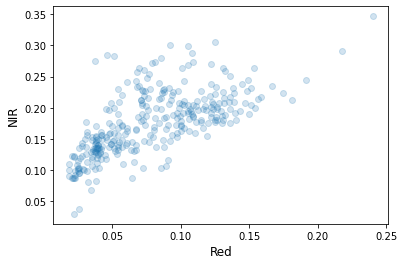

In [161]:
# Import the matplotlib.pyplot module.
import matplotlib.pyplot as plt

# Fetch a Landsat image.
img = ee.Image('LANDSAT/LT05/C01/T1_SR/LT05_034033_20000913')

# Select Red and NIR bands, scale them, and sample 500 points.
samp_fc = img.select(['B3','B4']).divide(10000).sample(scale=30, numPixels=500)

# Arrange the sample as a list of lists.
samp_dict = samp_fc.reduceColumns(ee.Reducer.toList().repeat(2), ['B3', 'B4'])
samp_list = ee.List(samp_dict.get('list'))

# Save server-side ee.List as a client-side Python list.
samp_data = samp_list.getInfo()

# Display a scatter plot of Red-NIR sample pairs using matplotlib.
plt.scatter(samp_data[0], samp_data[1], alpha=0.2)
plt.xlabel('Red', fontsize=12)
plt.ylabel('NIR', fontsize=12)
plt.show()

# **GEEMAP**

In [3]:
import geemap
u_lat = 47.4779
u_lon = 19.04
Map = geemap.Map(center=[u_lat,u_lon], zoom= 8)
Map

Map(center=[47.4779, 19.04], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(child…